In [1]:
#! pip install catboost
#! pip install scikit-learn --force
#! pip install openpyxl

In [2]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
import os

pd.set_option('display.max.columns',300)

from core.calculator.storage import ModelDB
from core.calculator.core import ForecastConfig
from core.calculator.core import TrainingManager
from core.calculator.core import ForecastEngine

from core.calculator.deposits import DepositsCalculationType
from core.calculator.deposits import DepositIterativeCalculator

from core.definitions import *
from core.project_update import load_portfolio

from core.models import DepositModels
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# Дата из который мы прогнозируем (пока что не меняется)
train_end = datetime(year=2023, month=5, day=31)

# Горизонт прогноза в месяцах
horizon = 6

In [5]:
# Данные для прогноза
scenario_data = {
    # ССВ
     'SSV':                  [0.48 for h in range(horizon)],
    # ФОР
     'FOR':                  [4 for h in range(horizon)],
    # Трансфертные ставки
     'VTB_ftp_rate_[90d]':   [8.05 for h in range(horizon)],
     'VTB_ftp_rate_[180d]':  [8.25 for h in range(horizon)],
     'VTB_ftp_rate_[365d]':  [8.55 for h in range(horizon)],
     'VTB_ftp_rate_[548d]':  [8.75 for h in range(horizon)],
     'VTB_ftp_rate_[730d]':  [9.15 for h in range(horizon)],
     'VTB_ftp_rate_[1095d]': [9.5 for h in range(horizon)],
    
    # Маржа бизнеса по срочностям
     'margin_[90d]':         [0.7 for h in range(horizon)],
     'margin_[180d]':        [0.7 for h in range(horizon)],
     'margin_[365d]':        [0.7 for h in range(horizon)],
     'margin_[548d]':        [0.7 for h in range(horizon)],
     'margin_[730d]':        [0.7 for h in range(horizon)],
     'margin_[1095d]':       [0.7 for h in range(horizon)],
    
    # Спред Привилегия - Массовый (на сколько в среднем ставки по сегменту Привилегия больше чем ставки по массовому сегменту)
     'priv_spread':          [0.0 for h in range(horizon)],
    # Спред ВИП - Массовый (на сколько в среднем ставки по сегменту ВИП больше чем ставки по массовому сегменту)
     'vip_spread':           [0.0 for h in range(horizon)],
    
    # Ниже три спреда по разным типам опциональности по отношению к безопциональным вкладам (Подразумевается, что они, как правило, отрицательные)
    # r - возможности пополнения, s - возможность расходных операций
    
    # На сколько ставка по расходным вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r0s1_spread':          [-7.2 for h in range(horizon)],
    
    # На сколько ставка по пополняемым вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r1s0_spread':          [-4.5+4 for h in range(horizon)],
    
    # На сколько ставка по расходно-пополняемым вкладам выше чем ставка по безопциональным вкладам (Если ниже - то со знаком минус)
     'r1s1_spread':          [-4.5+4 for h in range(horizon)],
    
    # Ставка по лучшему предложению сбера
     'SBER_max_rate':        [9.5 for h in range(horizon)],
    
    # Базовая ставка по НС
     'SA_rate':              [5 for h in range(horizon)]
}
scenario_df_user = pd.DataFrame(scenario_data)

In [6]:
scenario_df_user

,SSV,FOR,VTB_ftp_rate_[90d],VTB_ftp_rate_[180d],VTB_ftp_rate_[365d],VTB_ftp_rate_[548d],VTB_ftp_rate_[730d],VTB_ftp_rate_[1095d],margin_[90d],margin_[180d],margin_[365d],margin_[548d],margin_[730d],margin_[1095d],priv_spread,vip_spread,r0s1_spread,r1s0_spread,r1s1_spread,SBER_max_rate,SA_rate
0,0.48,4,8.05,8.25,8.55,8.75,9.15,9.5,0.7,0.7,0.7,0.7,0.7,0.7,0.0,0.0,-7.2,-0.5,-0.5,9.5,5
1,0.48,4,8.05,8.25,8.55,8.75,9.15,9.5,0.7,0.7,0.7,0.7,0.7,0.7,0.0,0.0,-7.2,-0.5,-0.5,9.5,5
2,0.48,4,8.05,8.25,8.55,8.75,9.15,9.5,0.7,0.7,0.7,0.7,0.7,0.7,0.0,0.0,-7.2,-0.5,-0.5,9.5,5
3,0.48,4,8.05,8.25,8.55,8.75,9.15,9.5,0.7,0.7,0.7,0.7,0.7,0.7,0.0,0.0,-7.2,-0.5,-0.5,9.5,5
4,0.48,4,8.05,8.25,8.55,8.75,9.15,9.5,0.7,0.7,0.7,0.7,0.7,0.7,0.0,0.0,-7.2,-0.5,-0.5,9.5,5
5,0.48,4,8.05,8.25,8.55,8.75,9.15,9.5,0.7,0.7,0.7,0.7,0.7,0.7,0.0,0.0,-7.2,-0.5,-0.5,9.5,5


In [7]:
scenario_df = preprocess_scenario(scenario_df_user, train_end, horizon)

In [8]:
scenario_df

,SBER_max_rate,rate_sa_weighted,VTB_ftp_rate_[90d],VTB_ftp_rate_[180d],VTB_ftp_rate_[365d],VTB_ftp_rate_[548d],VTB_ftp_rate_[730d],VTB_ftp_rate_[1095d],VTB_weighted_rate_[mass]_[r0s0]_[90d],VTB_weighted_rate_[mass]_[r0s0]_[180d],VTB_weighted_rate_[mass]_[r0s0]_[365d],VTB_weighted_rate_[mass]_[r0s0]_[548d],VTB_weighted_rate_[mass]_[r0s0]_[730d],VTB_weighted_rate_[mass]_[r0s0]_[1095d],VTB_weighted_rate_[mass]_[r0s1]_[90d],VTB_weighted_rate_[mass]_[r0s1]_[180d],VTB_weighted_rate_[mass]_[r0s1]_[365d],VTB_weighted_rate_[mass]_[r0s1]_[548d],VTB_weighted_rate_[mass]_[r0s1]_[730d],VTB_weighted_rate_[mass]_[r0s1]_[1095d],VTB_weighted_rate_[mass]_[r1s0]_[90d],VTB_weighted_rate_[mass]_[r1s0]_[180d],VTB_weighted_rate_[mass]_[r1s0]_[365d],VTB_weighted_rate_[mass]_[r1s0]_[548d],VTB_weighted_rate_[mass]_[r1s0]_[730d],VTB_weighted_rate_[mass]_[r1s0]_[1095d],VTB_weighted_rate_[mass]_[r1s1]_[90d],VTB_weighted_rate_[mass]_[r1s1]_[180d],VTB_weighted_rate_[mass]_[r1s1]_[365d],VTB_weighted_rate_[mass]_[r1s1]_[548d],VTB_weighted_rate_[mass]_[r1s1]_[730d],VTB_weighted_rate_[mass]_[r1s1]_[1095d],VTB_weighted_rate_[priv]_[r0s0]_[90d],VTB_weighted_rate_[priv]_[r0s0]_[180d],VTB_weighted_rate_[priv]_[r0s0]_[365d],VTB_weighted_rate_[priv]_[r0s0]_[548d],VTB_weighted_rate_[priv]_[r0s0]_[730d],VTB_weighted_rate_[priv]_[r0s0]_[1095d],VTB_weighted_rate_[priv]_[r0s1]_[90d],VTB_weighted_rate_[priv]_[r0s1]_[180d],VTB_weighted_rate_[priv]_[r0s1]_[365d],VTB_weighted_rate_[priv]_[r0s1]_[548d],VTB_weighted_rate_[priv]_[r0s1]_[730d],VTB_weighted_rate_[priv]_[r0s1]_[1095d],VTB_weighted_rate_[priv]_[r1s0]_[90d],VTB_weighted_rate_[priv]_[r1s0]_[180d],VTB_weighted_rate_[priv]_[r1s0]_[365d],VTB_weighted_rate_[priv]_[r1s0]_[548d],VTB_weighted_rate_[priv]_[r1s0]_[730d],VTB_weighted_rate_[priv]_[r1s0]_[1095d],VTB_weighted_rate_[priv]_[r1s1]_[90d],VTB_weighted_rate_[priv]_[r1s1]_[180d],VTB_weighted_rate_[priv]_[r1s1]_[365d],VTB_weighted_rate_[priv]_[r1s1]_[548d],VTB_weighted_rate_[priv]_[r1s1]_[730d],VTB_weighted_rate_[priv]_[r1s1]_[1095d],VTB_weighted_rate_[vip]_[r0s0]_[90d],VTB_weighted_rate_[vip]_[r0s0]_[180d],VTB_weighted_rate_[vip]_[r0s0]_[365d],VTB_weighted_rate_[vip]_[r0s0]_[548d],VTB_weighted_rate_[vip]_[r0s0]_[730d],VTB_weighted_rate_[vip]_[r0s0]_[1095d],VTB_weighted_rate_[vip]_[r0s1]_[90d],VTB_weighted_rate_[vip]_[r0s1]_[180d],VTB_weighted_rate_[vip]_[r0s1]_[365d],VTB_weighted_rate_[vip]_[r0s1]_[548d],VTB_weighted_rate_[vip]_[r0s1]_[730d],VTB_weighted_rate_[vip]_[r0s1]_[1095d],VTB_weighted_rate_[vip]_[r1s0]_[90d],VTB_weighted_rate_[vip]_[r1s0]_[180d],VTB_weighted_rate_[vip]_[r1s0]_[365d],VTB_weighted_rate_[vip]_[r1s0]_[548d],VTB_weighted_rate_[vip]_[r1s0]_[730d],VTB_weighted_rate_[vip]_[r1s0]_[1095d],VTB_weighted_rate_[vip]_[r1s1]_[90d],VTB_weighted_rate_[vip]_[r1s1]_[180d],VTB_weighted_rate_[vip]_[r1s1]_[365d],VTB_weighted_rate_[vip]_[r1s1]_[548d],VTB_weighted_rate_[vip]_[r1s1]_[730d],VTB_weighted_rate_[vip]_[r1s1]_[1095d]
2023-06-30,9.5,5.0,8.05,8.25,8.55,8.75,9.15,9.5,7.205417,7.41375,7.72625,7.934583,8.35125,8.715833,0.005417,0.21375,0.52625,0.734583,1.15125,1.515833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833,7.205417,7.41375,7.72625,7.934583,8.35125,8.715833,0.005417,0.21375,0.52625,0.734583,1.15125,1.515833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833,7.205417,7.41375,7.72625,7.934583,8.35125,8.715833,0.005417,0.21375,0.52625,0.734583,1.15125,1.515833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833
2023-07-31,9.5,5.0,8.05,8.25,8.55,8.75,9.15,9.5,7.205417,7.41375,7.72625,7.934583,8.35125,8.715833,0.005417,0.21375,0.52625,0.734583,1.15125,1.515833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833,7.205417,7.41375,7.72625,7.934583,8.35125,8.715833,0.005417,0.21375,0.52625,0.734583,1.15125,1.515833,6.705417,6.91375,7.22625,7.434583,7.85125,8.215833

In [9]:
port_folder = '../data/portfolio_data'
portfolio = load_portfolio(train_end, port_folder)

In [10]:
# если хотим обучить модели

from core.models.utils import run_spark_session
spark = run_spark_session('check_calc')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/27 14:14:20 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
23/06/27 14:14:21 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
23/06/27 14:14:23 WARN yarn.Client: Same path resource file:///opt/cloudera/parcels/AnacondaPy37/jars/spark-tree-plotting-0.2.jar added multiple times to distributed cache.
23/06/27 14:14:46 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyExceptio

In [11]:
folder = '../data/trained_models'

sqlite_filepath = os.path.join(folder, 'modeldb_test.bin')

DB_URL = f"sqlite:///{sqlite_filepath}"
model_db = ModelDB(DB_URL)
spark = None

In [12]:
ENV_NAME = 'hmelevskoi_env'

os.environ['CC'] = 'x86_64-conda-linux-gnu-gcc'
os.environ['CXX'] = 'x86_64-conda-linux-gnu-g++'
os.environ['PATH'] = os.path.abspath(f'/tmp/envs/{ENV_NAME}/bin') + ':' + os.environ['PATH']

In [13]:
config: ForecastConfig = ForecastConfig(
    first_train_end_dt = train_end,
    horizon = horizon,
    trainers = DepositModels.trainers,
    data_loaders = DepositModels.dataloaders,
    calculator_type = DepositIterativeCalculator,
    calc_type = DepositsCalculationType.Deposits.Deposits,
    adapter_types = DepositModels.adapter_types,
    scenario_data = scenario_df,
    portfolio = portfolio
)
    
training_manager = TrainingManager(spark, config.trainers, folder, model_db)   
engine: ForecastEngine = ForecastEngine(spark, config, training_manager, overwrite_models=False)

In [14]:
%%time
engine.run_all()

INFO:core:missing models: []
INFO:core:add_models_from_bytes
INFO:core:plan_close_201402_202305 - adapter <class 'core.models.plan_close.plan_close_model.PlanCloseModelAdapter'>
INFO:core:renewal_model_201401_202305 - adapter <class 'core.models.renewal.renewal_model.RenewalModelAdapter'>
INFO:core:current_accounts_model_201002_202305 - adapter <class 'core.models.current_accounts.current_accounts_model.CurrentAccountsModelAdapter'>
INFO:core:maturity_structure_mass_r0s0_201401_202305 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S0ModelAdapter'>
INFO:core:maturity_structure_mass_r0s1_202001_202305 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S1ModelAdapter'>
INFO:core:maturity_structure_mass_r1s0_201401_202305 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S0ModelAdapter'>
INFO:core:m

CPU times: user 33.1 s, sys: 5.46 s, total: 38.5 s
Wall time: 26.9 s


In [15]:
portfolio_res = engine.calc_results['portfolio']
agg_res = engine.calc_results['agg_data']

KeyError: 'portfolio'

In [66]:
#base
agg_res.groupby(by=['report_dt','segment']).sum()[['balance','newbusiness','contract_close','early_withdrawal',	'operations','interests','renewal']]/10**9

balance  newbusiness  contract_close  \
report_dt  segment                                             
2023-05-31 mass      916.903720   125.319842      -98.441562   
           priv      955.219189   153.763433     -124.916662   
           vip      1213.189449   118.368766     -190.992617   
2023-06-30 mass      945.349266   128.082498      -99.066112   
           priv      980.608012   172.427178     -151.238622   
           vip      1326.229957   121.984429     -146.990428   
2023-07-31 mass      976.451164   107.371699      -73.189064   
           priv     1024.653947   105.394298      -63.671757   
           vip      1484.971498   126.942774     -108.848944   
2023-08-31 mass     1002.956665   125.131085      -95.612330   
           priv     1064.141617   121.391365      -84.558920   
           vip      1722.398383   124.320049      -40.335480   
2023-09-30 mass     1008.999989   200.126046     -190.375689   
           priv     1084.338524   177.915991     -158.362390   
           vip      1964.835874   132.131639      -57.415389   
2023-10-31 mass     1027.820250   135.954466     -109.285662   
           priv     1117.820499   131.069931      -97.196097   
           vip      2216.111172   132.355633      -62.564492   

                    early_withdrawal  operations  interests    renewal  
report_dt  segment                                                      
2023-05-31 mass            -9.149496   -0.085015   4.605097  21.773845  
           priv            -6.156105    8.915189   4.590723  20.798546  
           vip             -1.563424   17.181237   6.245510  24.022134  
2023-06-30 mass            -9.114394    3.827740   4.715814  24.273186  
           priv            -5.783401    5.391268   4.592400  33.977209  
           vip             -1.149753  133.176310   6.019949  20.508622  
2023-07-31 mass            -9.318680    1.177686   5.060257  19.835573  
           priv            -7.212026    4.236143   5.299277  24.748841  
           vip             -1.180435  135.294194   6.533953  10.146287  
2023-08-31 mass            -8.183891    0.111652   5.058985  27.257280  
           priv            -6.883360    4.120369   5.418215  31.002022  
           vip             -1.192956  147.121141   7.514131  23.282909  
2023-09-30 mass            -8.505366    0.177946   4.620386  33.903075  
           priv            -7.425387    2.973129   5.095564  65.717800  
           vip             -1.222137  160.532578   8.410799  46.804216  
2023-10-31 mass           -10.345072   -2.641693   5.138222  24.565721  
           priv            -9.036931    2.903642   5.741431  22.113964  
           vip             -1.272209  173.150358   9.606008  13.359308

In [81]:
agg_res.groupby(by=['report_dt','segment']).sum()[['balance','newbusiness','contract_close','early_withdrawal',	'operations'	,'interests','renewal']]/10**9

balance  newbusiness  contract_close  \
report_dt  segment                                             
2023-05-31 mass      915.261180   132.581946      -98.441562   
           priv      939.270705   158.493896     -124.916662   
           vip      1221.912633   181.962499     -190.992617   
2023-06-30 mass      940.905393   132.535658      -98.455215   
           priv      959.695028   173.158968     -148.951541   
           vip      1204.261712   168.505514     -157.188114   
2023-07-31 mass      972.696089   111.374017      -71.751883   
           priv     1000.029753   105.141773      -60.015971   
           vip      1247.115547   163.331087      -96.179623   
2023-08-31 mass     1000.960423   130.541854      -95.968039   
           priv     1035.897323   121.313074      -81.130629   
           vip      1350.045276   162.398436      -36.127312   
2023-09-30 mass     1008.696803   205.100942     -190.257551   
           priv     1053.837895   176.735292     -153.494700   
           vip      1450.684600   170.284595      -47.589079   
2023-10-31 mass     1031.806580   140.989808     -109.188372   
           priv     1084.868225   131.107841      -93.919529   
           vip      1556.018933   170.292816      -45.075971   

                    early_withdrawal  operations  interests    renewal  
report_dt  segment                                                      
2023-05-31 mass            -9.149496   -8.950661   4.566099  21.773845  
           priv            -6.156105  -11.701171   4.528136  20.798546  
           vip             -1.563424  -37.594506   6.150704  24.022134  
2023-06-30 mass            -9.261779   -3.933068   4.758618  24.196992  
           priv            -4.439335   -3.905161   4.561392  32.956090  
           vip             -1.193400  -33.929327   6.154405  24.133329  
2023-07-31 mass            -9.505816   -3.483217   5.157595  19.577525  
           priv            -5.017428   -5.111294   5.337645  22.914339  
           vip             -1.259051  -29.506235   6.467658   9.713826  
2023-08-31 mass            -8.402016   -3.099003   5.191539  27.929738  
           priv            -4.691800   -5.094839   5.471765  27.676560  
           vip             -1.272145  -29.124864   7.055614  20.916590  
2023-09-30 mass            -8.793119   -3.129034   4.815141  34.074218  
           priv            -4.839798   -5.590541   5.130319  62.039142  
           vip             -1.275460  -28.309454   7.528721  42.875720  
2023-10-31 mass           -10.645904   -3.477003   5.431248  24.761034  
           priv            -5.661670   -6.366220   5.869907  19.099241  
           vip             -1.309281  -26.935806   8.362575   9.531685

In [12]:
#base
port_summary=agg_res.groupby(by='report_dt').sum()[['balance','newbusiness','contract_close','early_withdrawal',	'operations'	,'interests','renewal']]
port_summary=port_summary/10**9
port_summary

,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal
report_dt,,,,,,,
2023-05-31,3079.157501,469.708595,-414.350841,-16.869025,-52.235914,15.277245,66.594524
2023-06-30,3107.942366,471.938740,-405.326754,-14.874716,-38.429267,15.476862,81.551813
2023-07-31,3222.491660,377.688724,-228.767625,-15.759491,-35.552565,16.940250,52.494428
2023-08-31,3389.430772,411.503222,-212.955058,-14.341214,-34.949562,17.681723,77.124770
2023-09-30,3515.536117,549.447898,-391.137235,-14.872590,-34.750455,17.417728,139.846070
2023-10-31,3674.615029,439.814924,-248.298426,-17.576639,-34.441326,19.580380,54.015980


In [63]:
port_summary=agg_res.groupby(by='report_dt').sum()[['balance','newbusiness','contract_close',	'early_withdrawal',	'operations'	,'interests','renewal']]
port_summary=port_summary/10**9
port_summary

,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal
report_dt,,,,,,,
2023-05-31,3085.312358,397.452041,-414.350841,-16.869025,26.011411,15.441331,66.594524
2023-06-30,3252.187235,422.494105,-397.295162,-16.047548,142.395319,15.328163,78.759017
2023-07-31,3486.076610,339.708771,-245.709764,-17.711141,140.708022,16.893486,54.730701
2023-08-31,3789.496665,370.842500,-220.506731,-16.260207,151.353161,17.991331,81.542210
2023-09-30,4058.174386,510.173677,-406.153468,-17.152889,163.683653,18.126749,146.425091
2023-10-31,4361.751920,399.380029,-269.046251,-20.654212,173.412307,20.485661,60.038993


In [68]:
features_sum=engine.calc._forecast_context.model_data['features']
features_sum

,SBER_max_rate,rate_sa_weighted,VTB_ftp_rate_[90d],VTB_ftp_rate_[180d],VTB_ftp_rate_[365d],VTB_ftp_rate_[548d],VTB_ftp_rate_[730d],VTB_ftp_rate_[1095d],VTB_weighted_rate_[mass]_[r0s0]_[90d],VTB_weighted_rate_[mass]_[r0s0]_[180d],VTB_weighted_rate_[mass]_[r0s0]_[365d],VTB_weighted_rate_[mass]_[r0s0]_[548d],VTB_weighted_rate_[mass]_[r0s0]_[730d],VTB_weighted_rate_[mass]_[r0s0]_[1095d],VTB_weighted_rate_[mass]_[r0s1]_[90d],VTB_weighted_rate_[mass]_[r0s1]_[180d],VTB_weighted_rate_[mass]_[r0s1]_[365d],VTB_weighted_rate_[mass]_[r0s1]_[548d],VTB_weighted_rate_[mass]_[r0s1]_[730d],VTB_weighted_rate_[mass]_[r0s1]_[1095d],VTB_weighted_rate_[mass]_[r1s0]_[90d],VTB_weighted_rate_[mass]_[r1s0]_[180d],VTB_weighted_rate_[mass]_[r1s0]_[365d],VTB_weighted_rate_[mass]_[r1s0]_[548d],VTB_weighted_rate_[mass]_[r1s0]_[730d],VTB_weighted_rate_[mass]_[r1s0]_[1095d],VTB_weighted_rate_[mass]_[r1s1]_[90d],VTB_weighted_rate_[mass]_[r1s1]_[180d],VTB_weighted_rate_[mass]_[r1s1]_[365d],VTB_weighted_rate_[mass]_[r1s1]_[548d],VTB_weighted_rate_[mass]_[r1s1]_[730d],VTB_weighted_rate_[mass]_[r1s1]_[1095d],VTB_weighted_rate_[priv]_[r0s0]_[90d],VTB_weighted_rate_[priv]_[r0s0]_[180d],VTB_weighted_rate_[priv]_[r0s0]_[365d],VTB_weighted_rate_[priv]_[r0s0]_[548d],VTB_weighted_rate_[priv]_[r0s0]_[730d],VTB_weighted_rate_[priv]_[r0s0]_[1095d],VTB_weighted_rate_[priv]_[r0s1]_[90d],VTB_weighted_rate_[priv]_[r0s1]_[180d],VTB_weighted_rate_[priv]_[r0s1]_[365d],VTB_weighted_rate_[priv]_[r0s1]_[548d],VTB_weighted_rate_[priv]_[r0s1]_[730d],VTB_weighted_rate_[priv]_[r0s1]_[1095d],VTB_weighted_rate_[priv]_[r1s0]_[90d],VTB_weighted_rate_[priv]_[r1s0]_[180d],VTB_weighted_rate_[priv]_[r1s0]_[365d],VTB_weighted_rate_[priv]_[r1s0]_[548d],VTB_weighted_rate_[priv]_[r1s0]_[730d],VTB_weighted_rate_[priv]_[r1s0]_[1095d],VTB_weighted_rate_[priv]_[r1s1]_[90d],VTB_weighted_rate_[priv]_[r1s1]_[180d],VTB_weighted_rate_[priv]_[r1s1]_[365d],VTB_weighted_rate_[priv]_[r1s1]_[548d],VTB_weighted_rate_[priv]_[r1s1]_[730d],VTB_weighted_rate_[priv]_[r1s1]_[1095d],VTB_weighted_rate_[vip]_[r0s0]_[90d],VTB_weighted_rate_[vip]_[r0s0]_[180d],VTB_weighted_rate_[vip]_[r0s0]_[365d],VTB_weighted_rate_[vip]_[r0s0]_[548d],VTB_weighted_rate_[vip]_[r0s0]_[730d],VTB_weighted_rate_[vip]_[r0s0]_[1095d],VTB_weighted_rate_[vip]_[r0s1]_[90d],VTB_weighted_rate_[vip]_[r0s1]_[180d],VTB_weighted_rate_[vip]_[r0s1]_[365d],VTB_weighted_rate_[vip]_[r0s1]_[548d],VTB_weighted_rate_[vip]_[r0s1]_[730d],VTB_weighted_rate_[vip]_[r0s1]_[1095d],VTB_weighted_rate_[vip]_[r1s0]_[90d],VTB_weighted_rate_[vip]_[r1s0]_[180d],VTB_weighted_rate_[vip]_[r1s0]_[365d],VTB_weighted_rate_[vip]_[r1s0]_[548d],VTB_weighted_rate_[vip]_[r1s0]_[730d],VTB_weighted_rate_[vip]_[r1s0]_[1095d],VTB_weighted_rate_[vip]_[r1s1]_[90d],VTB_weighted_rate_[vip]_[r1s1]_[180d],VTB_weighted_rate_[vip]_[r1s1]_[365d],VTB_weighted_rate_[vip]_[r1s1]_[548d],VTB_weighted_rate_[vip]_[r1s1]_[730d],VTB_weighted_rate_[vip]_[r1s1]_[1095d],plan_close_[mass],plan_close_[priv],plan_close_[vip],y_inflow_share_[mass]_[r0s0]_[90d],y_inflow_share_[mass]_[r0s0]_[180d],y_inflow_share_[mass]_[r0s0]_[365d],y_inflow_share_[mass]_[r0s0]_[548d],y_inflow_share_[mass]_[r0s0]_[730d],y_inflow_share_[mass]_[r0s0]_[1095d],VTB_weighted_rate_[mass]_[r0s0],y_inflow_share_[mass]_[r0s1]_[90d],y_inflow_share_[mass]_[r0s1]_[180d],y_inflow_share_[mass]_[r0s1]_[365d],y_inflow_share_[mass]_[r0s1]_[548d],y_inflow_share_[mass]_[r0s1]_[730d],y_inflow_share_[mass]_[r0s1]_[1095d],VTB_weighted_rate_[mass]_[r0s1],y_inflow_share_[mass]_[r1s0]_[90d],y_inflow_share_[mass]_[r1s0]_[180d],y_inflow_share_[mass]_[r1s0]_[365d],y_inflow_share_[mass]_[r1s0]_[548d],y_inflow_share_[mass]_[r1s0]_[730d],y_inflow_share_[mass]_[r1s0]_[1095d],VTB_weighted_rate_[mass]_[r1s0],y_inflow_share_[mass]_[r1s1]_[90d],y_inflow_share_[mass]_[r1s1]_[180d],y_inflow_share_[mass]_[r1s1]_[365d],y_inflow_share_[mass]_[r1s1]_[548d],y_inflow_share_[mass]_[r1s1]_[730d],y_inflow_share_[mass]_[r1s1]_[1095d],VTB_weighted_rate_[mass]_[r1s1],y_inflow_share_[pri

In [130]:
total_by_mat=pd.DataFrame(0,columns=MATURITY_,index=features_sum.index)
total_by_mat=total_by_mat.add_suffix('d')
for mat in MATURITY_:
    for segment in DEFAULT_SEGMENTS_:
        for repl, sub in OPTIONALS_:
            total_by_mat[str(mat)+'d']+=features_sum[f'y_inflow_[{segment}]_[r{repl}s{sub}]_[{mat}d]']
total_by_mat['Total']=features_sum['y_inflow']

In [131]:
total_by_mat

,90d,180d,365d,548d,730d,1095d,Total
report_dt,,,,,,,
2023-04-30,4.281482e+10,1.100095e+11,1.333475e+11,4.710849e+10,5.134304e+10,4.543628e+10,4.300596e+11
2023-05-31,4.965172e+10,1.234559e+11,1.471538e+11,5.381269e+10,5.718655e+10,5.265763e+10,4.839182e+11
2023-06-30,5.176560e+10,1.262267e+11,1.468088e+11,5.499912e+10,5.772266e+10,5.465451e+10,4.921774e+11
2023-07-31,3.625736e+10,9.489441e+10,1.183332e+11,4.099413e+10,4.523127e+10,3.846512e+10,3.741755e+11
2023-08-31,4.469372e+10,1.126686e+11,1.319398e+11,4.700451e+10,4.980927e+10,4.537880e+10,4.314947e+11
2023-09-30,6.388687e+10,1.536960e+11,1.648609e+11,6.111217e+10,6.090467e+10,6.135746e+10,5.658181e+11
2023-10-31,4.281159e+10,1.093710e+11,1.312054e+11,4.620969e+10,4.949171e+10,4.393129e+10,4.230206e+11
2023-11-30,4.077375e+10,1.058799e+11,1.312027e+11,4.567854e+10,4.955180e+10,4.255067e+10,4.156374e+11
2023-12-31,4.550157e+10,1.137242e+11,1.329704e+11,4.860455e+10,5.191620e+10,4.788578e+10,4.406027e+11


In [132]:
#check
total_by_mat['Total']-total_by_mat['90d']-total_by_mat['180d']-total_by_mat['365d']-total_by_mat['548d']-total_by_mat['730d']-total_by_mat['1095d']

report_dt
2023-04-30    0.000053
2023-05-31   -0.000038
2023-06-30   -0.000084
2023-07-31   -0.000008
2023-08-31   -0.000031
2023-09-30   -0.000031
2023-10-31    0.000008
2023-11-30   -0.000069
2023-12-31   -0.000092
2024-01-31    0.000046
2024-02-29   -0.000061
2024-03-31    0.000015
dtype: float64

In [133]:
for mat in MATURITY_:
    total_by_mat[str(mat)+'d']=total_by_mat[str(mat)+'d']/total_by_mat['Total']
total_by_mat

,90d,180d,365d,548d,730d,1095d,Total
report_dt,,,,,,,
2023-04-30,0.099556,0.255801,0.310068,0.109539,0.119386,0.105651,4.300596e+11
2023-05-31,0.102604,0.255117,0.304088,0.111202,0.118174,0.108815,4.839182e+11
2023-06-30,0.105177,0.256466,0.298284,0.111747,0.117280,0.111046,4.921774e+11
2023-07-31,0.096899,0.253609,0.316251,0.109559,0.120882,0.102800,3.741755e+11
2023-08-31,0.103579,0.261112,0.305774,0.108934,0.115434,0.105167,4.314947e+11
2023-09-30,0.112911,0.271635,0.291367,0.108007,0.107640,0.108440,5.658181e+11
2023-10-31,0.101204,0.258548,0.310163,0.109237,0.116996,0.103851,4.230206e+11
2023-11-30,0.098099,0.254741,0.315666,0.109900,0.119219,0.102375,4.156374e+11
2023-12-31,0.103271,0.258111,0.301792,0.110314,0.117830,0.108682,4.406027e+11


# save resuts

In [11]:
agg_res.to_csv("agg_res.csv")

In [55]:
from datetime import datetime
portfolio_res['month_buckets']=(pd.to_datetime(portfolio_res['close_month']).dt.year-portfolio_res['report_dt'].dt.year)*12+\
pd.to_datetime(portfolio_res['close_month']).dt.month-portfolio_res['report_dt'].dt.month

In [62]:
def to_buckets(x):
    if x<2:
        return '1M'
    if x<4:
        return '3M'
    if x<7:
        return '6M'
    if x<10:
        return '9M'
    if x<12:
        return '11M'
    if x<13:
        return '1Y'
    if x<19:
        return '18M'
    if x<25:
        return '2Y'
    if x<31:
        return '30M'
    if x<37:
        return '3Y'
    if x<43:
        return '42M'
    if x<61:
        return '5Y'
       
        


In [69]:
portfolio_res['time_buckets']=pd.DataFrame(portfolio_res['month_buckets']).applymap(to_buckets)['month_buckets']
pr=portfolio_res.groupby(by=['report_dt','time_buckets']).sum().reset_index()[['report_dt','time_buckets','balance']]

In [78]:
pr.to_csv('portfolio_by_backets.csv')

In [65]:
engine.calc._forecast_context.model_data['features'].to_csv('features.csv')

# Uploading scenario from file

In [9]:
for_scen=pd.read_excel('/home/vtb70174694/DFL/dynbalance/forecasting/Сценарий_июнь.xlsx')
for_scen.index=for_scen['Tech_name']

In [10]:
names_list=for_scen.index.dropna()

In [22]:
scenario_df_from_file=pd.DataFrame()

In [23]:
for name in names_list:
    scenario_df_from_file[name]=for_scen.loc[name][2:].values

In [24]:
scenario_df_from_file[0:]

,SSV,FOR,VTB_ftp_rate_[90d],VTB_ftp_rate_[180d],VTB_ftp_rate_[365d],VTB_ftp_rate_[548d],VTB_ftp_rate_[730d],VTB_ftp_rate_[1095d],r1s0_spread_[90d],r1s0_spread_[180d],r1s0_spread_[365d],r1s0_spread_[548d],r1s0_spread_[730d],r1s0_spread_[1095d],r1s1_spread_[90d],r1s1_spread_[180d],r1s1_spread_[365d],r1s1_spread_[548d],r1s1_spread_[730d],r1s1_spread_[1095d],SBER_max_rate,SA_rate,margin_r0s0_[90d],margin_r0s0_[180d],margin_r0s0_[365d],margin_r0s0_[548d],margin_r0s0_[730d],margin_r0s0_[1095d],priv_spread_r0s0_[90d],priv_spread_r0s0_[180d],priv_spread_r0s0_[365d],priv_spread_r0s0_[548d],priv_spread_r0s0_[730d],priv_spread_r0s0_[1095d],vip_spread_r0s0_[90d],vip_spread_r0s0_[180d],vip_spread_r0s0_[365d],vip_spread_r0s0_[548d],vip_spread_r0s0_[730d],vip_spread_r0s0_[1095d],но пока привлекаем только на 6 мес.,margin_N2B_[90d],margin_N2B_[180d],margin_N2B_[365d],margin_N2B_[548d],margin_N2B_[730d],margin_N2B_[1095d],priv_spread_N2B_[90d],priv_spread_N2B_[180d],priv_spread_N2B_[365d],priv_spread_N2B_[548d],priv_spread_N2B_[730d],priv_spread_N2B_[1095d],vip_spread_N2B_[90d],vip_spread_N2B_[180d],vip_spread_N2B_[365d],vip_spread_N2B_[548d],vip_spread_N2B_[730d],vip_spread_N2B_[1095d],margin_r1s0_[90d],margin_r1s0_[180d],margin_r1s0_[365d],margin_r1s0_[548d],margin_r1s0_[730d],margin_r1s0_[1095d],priv_spread_r1s0_[90d],priv_spread_r1s0_[180d],priv_spread_r1s0_[365d],priv_spread_r1s0_[548d],priv_spread_r1s0_[730d],priv_spread_r1s0_[1095d],vip_spread_r1s0_[90d],vip_spread_r1s0_[180d],vip_spread_r1s0_[365d],vip_spread_r1s0_[548d],vip_spread_r1s0_[730d],vip_spread_r1s0_[1095d],margin_r1s1_[90d],margin_r1s1_[180d],margin_r1s1_[365d],margin_r1s1_[548d],margin_r1s1_[730d],margin_r1s1_[1095d],priv_spread_r1s1_[90d],priv_spread_r1s1_[180d],priv_spread_r1s1_[365d],priv_spread_r1s1_[548d],priv_spread_r1s1_[730d],priv_spread_r1s1_[1095d],vip_spread_r1s1_[90d],vip_spread_r1s1_[180d],vip_spread_r1s1_[365d],vip_spread_r1s1_[548d],vip_spread_r1s1_[730d],vip_spread_r1s1_[1095d]
0,0.48,4.5,8.1,8.35,8.55,8.85,9.15,9.5,0.17,0.28,0.48,0.56,0.64,0.72,0.24,0.38,0.64,0.75,0.86,0.97,8.18,5,0.5555,0.54425,0.43525,0.39175,0.50825,0.2025,-0.2,-0.19,-0.19,-0.18,-0.21,0,-0.3,-0.29,-0.28,-0.27,-0.3,0,2023-06-30,-0.38,-0.38,-0.38,-0.38,-0.38,-0.38,0,0,0,0,0,0,0,0,0,0,0,0,1.09315,3.22685,3.78685,4.43695,4.64705,4.9049,-0.75,-2.65,-2.4,-1.83,-1.32,-0.56,-0.85,-2.75,-2.64,-2.3,-1.78,-0.78,1.0263,3.13135,3.63405,4.2555,4.43695,4.66615,-0.75,-2.65,-2.4,-1.83,-1.32,-0.56,-0.85,-2.75,-2.64,-2.3,-1.78,-0.78
1,0.48,4.5,8.1,8.35,8.55,8.85,9.15,9.5,0.17,0.28,0.48,0.56,0.64,0.72,0.24,0.38,0.64,0.75,0.86,0.97,8.18,5,0.5555,0.54425,0.43525,0.39175,0.50825,0.2025,-0.2,-0.19,-0.19,-0.18,-0.21,0,-0.3,-0.29,-0.28,-0.27,-0.3,0,2023-07-31,-0.38,-0.38,-0.38,-0.38,-0.38,-0.38,0,0,0,0,0,0,0,0,0,0,0,0,1.09315,3.22685,3.78685,4.43695,4.64705,4.9049,-0.75,-2.65,-2.4,-1.83,-1.32,-0.56,-0.85,-2.75,-2.64,-2.3,-1.78,-0.78,1.0263,3.13135,3.63405,4.2555,4.43695,4.66615,-0.75,-2.65,-2.4,-1.83,-1.32,-0.56,-0.85,-2.75,-2.64,-2.3,-1.78,-0.78
2,0.48,4.5,8.1,8.35,8.55,8.85,9.15,9.5,0.17,0.28,0.48,0.56,0.64,0.72,0.24,0.38,0.64,0.75,0.86,0.97,8.18,5,0.5555,0.54425,0.43525,0.39175,0.50825,0.2025,-0.2,-0.19,-0.19,-0.18,-0.21,0,-0.3,-0.29,-0.28,-0.27,-0.3,0,2023-08-31,-0.38,-0.38,-0.38,-0.38,-0.38,-0.38,0,0,0,0,0,0,0,0,0,0,0,0,1.09315,3.22685,3.78685,4.43695,4.64705,4.9049,-0.75,-2.65,-2.4,-1.83,-1.32,-0.56,-0.85,-2.75,-2.64,-2.3,-1.78,-0.78,1.0263,3.13135,3.63405,4.2555,4.43695,4.66615,-0.75,-2.65,-2.4,-1.83,-1.32,-0.56,-0.85,-2.75,-2.64,-2.3,-1.78,-0.78
3,0.48,4.5,8.1,8.35,8.55,8.85,9.15,9.5,0.17,0.28,0.48,0.56,0.64,0.72,0.24,0.38,0.64,0.75,0.86,0.97,8.18,5,0.5555,0.54425,0.43525,0.39175,0.50825,0.2025,-0.2,-0.19,-0.19,-0.18,-0.21,0,-0.3,-0.29,-0.28,-0.27,-0.3,0,2023-09-30,-0.38,-0.38,-0.38,-0.38,-0.38,-0.38,0,0,0,0,0,0,0,0,0,0,0,0,1.09315,3.22685,3.78685,4.43695,4.64705,4.9049,-0.75,-2.65,-2.4,-1.83,-1.32,-0.56,-0.85,-2.75,-2.64,-2.3,-1.78,-0.78,1.0263,3.13135,3.63405,4.2555,4.43695,4.66615,-0.75,-2.65,-2.4,-1.8

In [25]:
def preprocess_scenario_from_file(scenario_df,train_end,horizon):
    for mat in MATURITY_:
        for repl, sub in OPTIONALS_:
            scenario_df.loc[:,f'mass_spread_r{repl}s{sub}_[{mat}d]'] = 0.0
    for mat in MATURITY_:
        for repl, sub in [(0,0),(0,1)]:            
            scenario_df.loc[:,f'r{repl}s{sub}_spread_[{mat}d]'] = 0.0
    for mat in MATURITY_:
        for repl, sub in [(0,1)]:
            scenario_df.loc[:,f'margin_r{repl}s{sub}_[{mat}d]'] = scenario_df.loc[:,f'margin_r0s0_[{mat}d]']
            for segment in DEFAULT_SEGMENTS_:
                scenario_df.loc[:,f'{segment}_spread_r{repl}s{sub}_[{mat}d]'] = scenario_df.loc[:,f'{segment}_spread_r0s0_[{mat}d]']   
    scenario_dates = pd.date_range(start = train_end + MonthEnd(1), periods=horizon, freq='M')
    res_df = pd.DataFrame(index = scenario_dates)
    res_df.loc[scenario_dates, SBER_RATE_] = scenario_df[SBER_RATE_].values
    res_df.loc[scenario_dates, SA_RATE_] = scenario_df[SA_RATE_].values
    res_df.loc[scenario_dates, FTP_RATES_] = scenario_df[FTP_RATES_].values
    for segment in DEFAULT_SEGMENTS_:
        for repl, sub in OPTIONALS_:
            for mat in MATURITY_:
                default_rates = scenario_df[f'VTB_ftp_rate_[{mat}d]'].values.reshape(horizon,1)*(1- scenario_df[FOR_].values/100) - scenario_df[SSV_].values
                rate_name = get_feature_name('VTB_weighted_rate', segment=segment, repl=repl, sub=sub, maturity=mat)
                res_df.loc[scenario_dates, rate_name] = default_rates - scenario_df[[f'margin_r{repl}s{sub}_[{mat}d]']].values-scenario_df[[f'{segment}_spread_r{repl}s{sub}_[{mat}d]']].values\
                - scenario_df[[f'r{repl}s{sub}_spread_[{mat}d]']].values*(1- scenario_df[FOR_].values/100)
                res_df.loc[scenario_dates, rate_name] = np.maximum(res_df.loc[scenario_dates, rate_name], 0)
    res_df = res_df.rename(columns = RENAME_SCENARIO_MAP_)
    return res_df

In [27]:
#scenario_df=scenario_df[4:]
train_end = datetime(year=2023, month=5, day=31)
scenario_df=preprocess_scenario_from_file(scenario_df_from_file,train_end, horizon=scenario_df_from_file.shape[0])

In [29]:
scenario_df

,SBER_max_rate,rate_sa_weighted,VTB_ftp_rate_[90d],VTB_ftp_rate_[180d],VTB_ftp_rate_[365d],VTB_ftp_rate_[548d],VTB_ftp_rate_[730d],VTB_ftp_rate_[1095d],VTB_weighted_rate_[mass]_[r0s0]_[90d],VTB_weighted_rate_[mass]_[r0s0]_[180d],VTB_weighted_rate_[mass]_[r0s0]_[365d],VTB_weighted_rate_[mass]_[r0s0]_[548d],VTB_weighted_rate_[mass]_[r0s0]_[730d],VTB_weighted_rate_[mass]_[r0s0]_[1095d],VTB_weighted_rate_[mass]_[r0s1]_[90d],VTB_weighted_rate_[mass]_[r0s1]_[180d],VTB_weighted_rate_[mass]_[r0s1]_[365d],VTB_weighted_rate_[mass]_[r0s1]_[548d],VTB_weighted_rate_[mass]_[r0s1]_[730d],VTB_weighted_rate_[mass]_[r0s1]_[1095d],VTB_weighted_rate_[mass]_[r1s0]_[90d],VTB_weighted_rate_[mass]_[r1s0]_[180d],VTB_weighted_rate_[mass]_[r1s0]_[365d],VTB_weighted_rate_[mass]_[r1s0]_[548d],VTB_weighted_rate_[mass]_[r1s0]_[730d],VTB_weighted_rate_[mass]_[r1s0]_[1095d],VTB_weighted_rate_[mass]_[r1s1]_[90d],VTB_weighted_rate_[mass]_[r1s1]_[180d],VTB_weighted_rate_[mass]_[r1s1]_[365d],VTB_weighted_rate_[mass]_[r1s1]_[548d],VTB_weighted_rate_[mass]_[r1s1]_[730d],VTB_weighted_rate_[mass]_[r1s1]_[1095d],VTB_weighted_rate_[priv]_[r0s0]_[90d],VTB_weighted_rate_[priv]_[r0s0]_[180d],VTB_weighted_rate_[priv]_[r0s0]_[365d],VTB_weighted_rate_[priv]_[r0s0]_[548d],VTB_weighted_rate_[priv]_[r0s0]_[730d],VTB_weighted_rate_[priv]_[r0s0]_[1095d],VTB_weighted_rate_[priv]_[r0s1]_[90d],VTB_weighted_rate_[priv]_[r0s1]_[180d],VTB_weighted_rate_[priv]_[r0s1]_[365d],VTB_weighted_rate_[priv]_[r0s1]_[548d],VTB_weighted_rate_[priv]_[r0s1]_[730d],VTB_weighted_rate_[priv]_[r0s1]_[1095d],VTB_weighted_rate_[priv]_[r1s0]_[90d],VTB_weighted_rate_[priv]_[r1s0]_[180d],VTB_weighted_rate_[priv]_[r1s0]_[365d],VTB_weighted_rate_[priv]_[r1s0]_[548d],VTB_weighted_rate_[priv]_[r1s0]_[730d],VTB_weighted_rate_[priv]_[r1s0]_[1095d],VTB_weighted_rate_[priv]_[r1s1]_[90d],VTB_weighted_rate_[priv]_[r1s1]_[180d],VTB_weighted_rate_[priv]_[r1s1]_[365d],VTB_weighted_rate_[priv]_[r1s1]_[548d],VTB_weighted_rate_[priv]_[r1s1]_[730d],VTB_weighted_rate_[priv]_[r1s1]_[1095d],VTB_weighted_rate_[vip]_[r0s0]_[90d],VTB_weighted_rate_[vip]_[r0s0]_[180d],VTB_weighted_rate_[vip]_[r0s0]_[365d],VTB_weighted_rate_[vip]_[r0s0]_[548d],VTB_weighted_rate_[vip]_[r0s0]_[730d],VTB_weighted_rate_[vip]_[r0s0]_[1095d],VTB_weighted_rate_[vip]_[r0s1]_[90d],VTB_weighted_rate_[vip]_[r0s1]_[180d],VTB_weighted_rate_[vip]_[r0s1]_[365d],VTB_weighted_rate_[vip]_[r0s1]_[548d],VTB_weighted_rate_[vip]_[r0s1]_[730d],VTB_weighted_rate_[vip]_[r0s1]_[1095d],VTB_weighted_rate_[vip]_[r1s0]_[90d],VTB_weighted_rate_[vip]_[r1s0]_[180d],VTB_weighted_rate_[vip]_[r1s0]_[365d],VTB_weighted_rate_[vip]_[r1s0]_[548d],VTB_weighted_rate_[vip]_[r1s0]_[730d],VTB_weighted_rate_[vip]_[r1s0]_[1095d],VTB_weighted_rate_[vip]_[r1s1]_[90d],VTB_weighted_rate_[vip]_[r1s1]_[180d],VTB_weighted_rate_[vip]_[r1s1]_[365d],VTB_weighted_rate_[vip]_[r1s1]_[548d],VTB_weighted_rate_[vip]_[r1s1]_[730d],VTB_weighted_rate_[vip]_[r1s1]_[1095d]
2023-06-30,8.18,5.0,8.1,8.35,8.55,8.85,9.15,9.5,6.7,6.95,7.25,7.58,7.75,8.39,6.7,6.95,7.25,7.58,7.75,8.39,6.0,4.0,3.44,3.0,3.0,3.0,6.0,4.0,3.44,3.0,3.0,3.0,6.9,7.14,7.44,7.76,7.96,8.39,6.9,7.14,7.44,7.76,7.96,8.39,6.75,6.65,5.84,4.83,4.32,3.56,6.75,6.65,5.84,4.83,4.32,3.56,7.0,7.24,7.53,7.85,8.05,8.39,7.0,7.24,7.53,7.85,8.05,8.39,6.85,6.75,6.08,5.3,4.78,3.78,6.85,6.75,6.08,5.3,4.78,3.78
2023-07-31,8.18,5.0,8.1,8.35,8.55,8.85,9.15,9.5,6.7,6.95,7.25,7.58,7.75,8.39,6.7,6.95,7.25,7.58,7.75,8.39,6.0,4.0,3.44,3.0,3.0,3.0,6.0,4.0,3.44,3.0,3.0,3.0,6.9,7.14,7.44,7.76,7.96,8.39,6.9,7.14,7.44,7.76,7.96,8.39,6.75,6.65,5.84,4.83,4.32,3.56,6.75,6.65,5.84,4.83,4.32,3.56,7.0,7.24,7.53,7.85,8.05,8.39,7.0,7.24,7.53,7.85,8.05,8.39,6.85,6.75,6.08,5.3,4.78,3.78,6.85,6.75,6.08,5.3,4.78,3.78
2023-08-31,8.18,5.0,8.1,8.35,8.55,8.85,9.15,9.5,6.7,6.95,7.25,7.58,7.75,8.39,6.7,6.95,7.25,7.58,7.75,8.39,6.0,4.0,3.44,3.0,3.0,3.0,6.0,4.0,3.44,3.0,3.0,3.0,6.9,7.14,7.44,7.76,7.96,8.39,6.9,7.14,7.44,7.76,7.96,8.39,6.75,6.65,5.84,4.83,4.32,3.56,6.75,6.65,5.84,4.83,4.32,3.56,7.0,7.24,7

In [143]:
scenario_df.to_csv("scenario.csv")

In [30]:
port_folder = '../data/portfolio_data'
portfolio = load_portfolio(train_end, port_folder)

In [31]:
folder = '../data/trained_models'

sqlite_filepath = os.path.join(folder, 'modeldb_test.bin')

DB_URL = f"sqlite:///{sqlite_filepath}"
model_db = ModelDB(DB_URL)
spark = None

In [32]:
config: ForecastConfig = ForecastConfig(
    first_train_end_dt = train_end,
    horizon = scenario_df.shape[0],
    trainers = DepositModels.trainers,
    data_loaders = DepositModels.dataloaders,
    calculator_type = DepositIterativeCalculator,
    calc_type = DepositsCalculationType.Deposits.Deposits,
    adapter_types = DepositModels.adapter_types,
    scenario_data = scenario_df,
    portfolio = portfolio
)
    
training_manager = TrainingManager(spark, config.trainers, folder, model_db)   
engine: ForecastEngine = ForecastEngine(spark, config, training_manager, overwrite_models=False)

In [33]:
%%time
engine.run_all()

INFO:core:missing models: []
INFO:core:add_models_from_bytes
INFO:core:plan_close_201402_202305 - adapter <class 'core.models.plan_close.plan_close_model.PlanCloseModelAdapter'>
INFO:core:renewal_model_201401_202305 - adapter <class 'core.models.renewal.renewal_model.RenewalModelAdapter'>
INFO:core:current_accounts_model_201002_202305 - adapter <class 'core.models.current_accounts.current_accounts_model.CurrentAccountsModelAdapter'>
INFO:core:maturity_structure_mass_r0s0_201401_202305 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S0ModelAdapter'>
INFO:core:maturity_structure_mass_r0s1_202001_202305 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR0S1ModelAdapter'>
INFO:core:maturity_structure_mass_r1s0_201401_202305 - adapter <class 'core.models.newbusiness.maturity_structure.maturity_structure_mass_model.MaturityStructureMassR1S0ModelAdapter'>
INFO:core:m

CPU times: user 38 s, sys: 5.55 s, total: 43.6 s
Wall time: 31.5 s


In [35]:
# Депозиты
portfolio_res = engine.calc_results['Deposits']['portfolio'] 
agg_res = engine.calc_results['Deposits']['agg_data']

In [51]:
portfolio_res.target_maturity_days.unique()

array([ 180,  365,   90,  548, 1095,  730])

In [36]:
engine.calc_results['Deposits']['portfolio'].head()

,report_dt,segment,replenishable_flg,subtraction_flg,month_maturity,target_maturity_days,bucketed_balance_nm,bucketed_balance,open_month,close_month,weight_rate,balance,renewal_cnt,operations_in_month,early_withdrawal_in_month,gen_name
0,2023-06-30,mass,0,0,6,180,1000k-2000k,4.0,2023-03,2023-09,7.479683,3.176286e+10,0.0,0.0,-3.156182e+08,2023-03_2023-09_4.0_7.0_8.0_0_0_0.0_RUR
1,2023-06-30,mass,0,0,6,180,400k-1000k,3.0,2023-03,2023-09,7.471984,3.065309e+10,0.0,0.0,-3.050808e+08,2023-03_2023-09_3.0_7.0_8.0_0_0_0.0_RUR
2,2023-06-30,mass,0,0,12,365,1000k-2000k,4.0,2022-09,2023-09,7.000000,2.549240e+10,0.0,0.0,-1.637384e+08,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR
3,2023-06-30,mass,0,0,12,365,400k-1000k,3.0,2022-09,2023-09,7.000000,1.772237e+10,0.0,0.0,-1.135927e+08,2022-09_2023-09_3.0_13.0_8.0_0_0_0.0_RUR
4,2023-06-30,mass,0,0,6,180,1000k-2000k,4.0,2023-06,2023-12,6.950000,1.685429e+10,0.0,0.0,0.000000e+00,2023-06_2023-12_4_7_7_0_0_0_RUR


In [37]:
engine.calc_results['Deposits']['agg_data'].head()

,report_dt,segment,replenishable_flg,subtraction_flg,target_maturity_days,start_balance_agg_report_dt,balance_gain,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal
0,2023-06-30,mass,0,0,90,3.131640e+12,-3.911963e+08,1.100448e+11,1.996155e+10,-2.042615e+10,-3.136957e+08,0.0,3.870970e+08,1.962004e+10
1,2023-06-30,mass,0,0,180,3.131640e+12,-6.232738e+08,3.517519e+11,4.545771e+10,-4.458914e+10,-3.357280e+09,0.0,1.865435e+09,1.965053e+07
2,2023-06-30,mass,0,0,365,3.131640e+12,8.154834e+09,2.952263e+11,2.694543e+10,-1.754894e+10,-2.871197e+09,0.0,1.629536e+09,6.829425e+07
3,2023-06-30,mass,0,0,548,3.131640e+12,8.081649e+09,1.515357e+10,1.058316e+10,-2.522579e+09,-6.685413e+06,0.0,2.775592e+07,2.271564e+07
4,2023-06-30,mass,0,0,730,3.131640e+12,6.897190e+08,1.491398e+09,6.901147e+08,-3.051134e+06,-1.777445e+06,0.0,4.432914e+06,1.495632e+06


In [38]:
agg_res.groupby('report_dt').agg({'start_balance_agg_report_dt': 'min', 'balance_gain': 'sum', 'balance': 'sum'})

,start_balance_agg_report_dt,balance_gain,balance
report_dt,,,
2023-06-30,3.131640e+12,5.257856e+10,3.184218e+12
2023-07-31,3.184218e+12,1.451912e+11,3.329410e+12
2023-08-31,3.329410e+12,1.802852e+11,3.509695e+12
2023-09-30,3.509695e+12,1.328762e+11,3.642571e+12
2023-10-31,3.642571e+12,1.574894e+11,3.800060e+12
2023-11-30,3.800060e+12,8.327470e+10,3.883335e+12
2023-12-31,3.883335e+12,1.837868e+11,4.067122e+12


In [39]:
engine.calc_results['SavingAccounts'] # накопительные счета

balance,report_dt,segment,general,kopilka,safe
0,2023-06-30,mass,7.203226e+11,1.115520e+11,6.087706e+11
1,2023-07-31,mass,7.169104e+11,1.115520e+11,6.053584e+11
2,2023-08-31,mass,7.185269e+11,1.115520e+11,6.069749e+11
3,2023-09-30,mass,7.223887e+11,1.115520e+11,6.108366e+11
4,2023-10-31,mass,7.204753e+11,1.115520e+11,6.089232e+11
5,2023-11-30,mass,7.183336e+11,1.115520e+11,6.067816e+11
6,2023-12-31,mass,7.171799e+11,1.115520e+11,6.056279e+11
7,2023-06-30,priv,3.353482e+11,5.413504e+10,2.812132e+11
8,2023-07-31,priv,3.295485e+11,5.413504e+10,2.754134e+11
9,2023-08-31,priv,3.316502e+11,5.413504e+10,2.775151e+11


In [54]:
engine.calc_results['CurrentAccounts'] # расчетные счета

,current_accounts_balance_rur
report_dt,
2023-06-30,6.011446e+11
2023-07-31,6.713650e+11
2023-08-31,6.776119e+11
2023-09-30,6.894261e+11
2023-10-31,6.936493e+11
2023-11-30,6.986929e+11
2023-12-31,7.306626e+11


In [41]:
agg_res

,report_dt,segment,replenishable_flg,subtraction_flg,target_maturity_days,start_balance_agg_report_dt,balance_gain,balance,newbusiness,contract_close,early_withdrawal,operations,interests,renewal
0,2023-06-30,mass,0,0,90,3.131640e+12,-3.911963e+08,1.100448e+11,1.996155e+10,-2.042615e+10,-3.136957e+08,0.0,3.870970e+08,1.962004e+10
1,2023-06-30,mass,0,0,180,3.131640e+12,-6.232738e+08,3.517519e+11,4.545771e+10,-4.458914e+10,-3.357280e+09,0.0,1.865435e+09,1.965053e+07
2,2023-06-30,mass,0,0,365,3.131640e+12,8.154834e+09,2.952263e+11,2.694543e+10,-1.754894e+10,-2.871197e+09,0.0,1.629536e+09,6.829425e+07
3,2023-06-30,mass,0,0,548,3.131640e+12,8.081649e+09,1.515357e+10,1.058316e+10,-2.522579e+09,-6.685413e+06,0.0,2.775592e+07,2.271564e+07
4,2023-06-30,mass,0,0,730,3.131640e+12,6.897190e+08,1.491398e+09,6.901147e+08,-3.051134e+06,-1.777445e+06,0.0,4.432914e+06,1.495632e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,2023-09-30,vip,0,1,365,3.509695e+12,-4.251512e+06,0.000000e+00,0.000000e+00,-4.251512e+06,0.000000e+00,0.0,0.000000e+00,0.000000e+00
399,2023-09-30,vip,1,0,365,3.509695e+12,-3.336555e+04,0.000000e+00,0.000000e+00,-3.336555e+04,0.000000e+00,0.0,0.000000e+00,0.000000e+00
400,2023-10-31,mass,1,0,365,3.642571e+12,-9.017627e+05,0.000000e+00,0.000000e+00,-9.017627e+05,0.000000e+00,0.0,0.000000e+00,0.000000e+00
401,2023-10-31,priv,0,1,365,3.642571e+12,-1.304670e+03,0.000000e+00,0.000000e+00,-1.304670e+03,0.000000e+00,0.0,0.000000e+00,0.000000e+00


In [42]:
port_summary=agg_res.groupby(by='report_dt').sum()['balance']
port_summary=port_summary/10**9
port_summary

report_dt
2023-06-30    3184.218275
2023-07-31    3329.409524
2023-08-31    3509.694745
2023-09-30    3642.570947
2023-10-31    3800.060322
2023-11-30    3883.335023
2023-12-31    4067.121819
Name: balance, dtype: float64

In [56]:
with pd.ExcelWriter("agg_res.xlsx") as writer:
    agg_res.to_excel(writer,sheet_name='Deposits',index=False)
    engine.calc_results['SavingAccounts'].to_excel(writer,sheet_name='SavingAccounts',index=False)
    engine.calc_results['CurrentAccounts'].to_excel(writer,sheet_name='CurrentAccounts',index=True)

In [43]:
mass = agg_res[agg_res['segment']=='mass']
priv = agg_res[agg_res['segment']=='priv']
vip = agg_res[agg_res['segment']=='vip']



needs_columns = ['balance', 
                'newbusiness', 
                'contract_close', 
                'early_withdrawal',
                'operations',
                'interests',
                'renewal']

mass = mass.groupby(['report_dt']).sum()[needs_columns]
priv = priv.groupby(['report_dt']).sum()[needs_columns]
vip = vip.groupby(['report_dt']).sum()[needs_columns]

### Построим графики

In [44]:
import matplotlib.pyplot as plt

In [45]:
mass.columns

Index(['balance', 'newbusiness', 'contract_close', 'early_withdrawal',
       'operations', 'interests', 'renewal'],
      dtype='object')

In [46]:
segments = [mass, priv, vip]

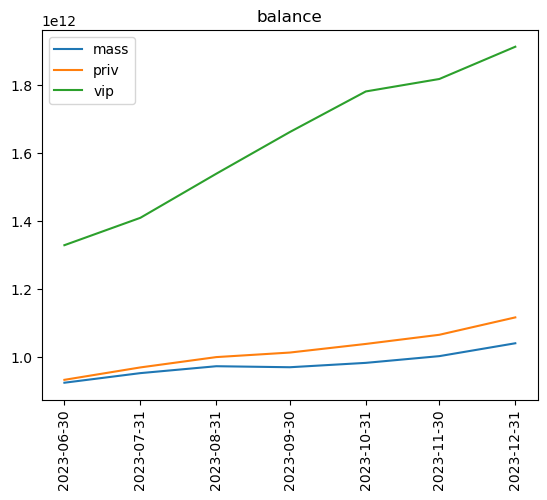

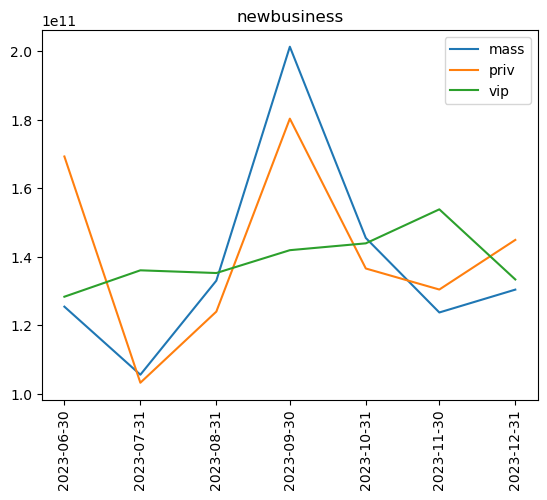

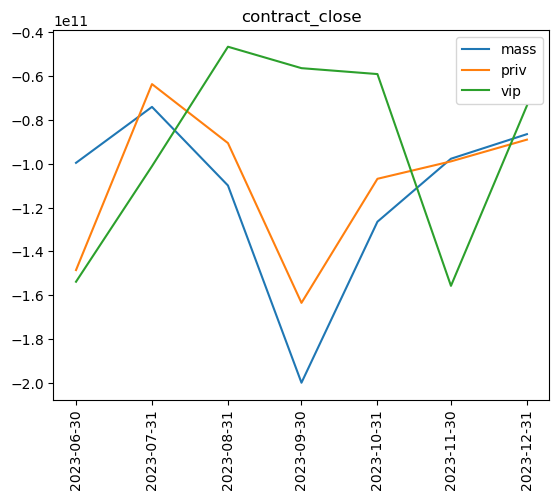

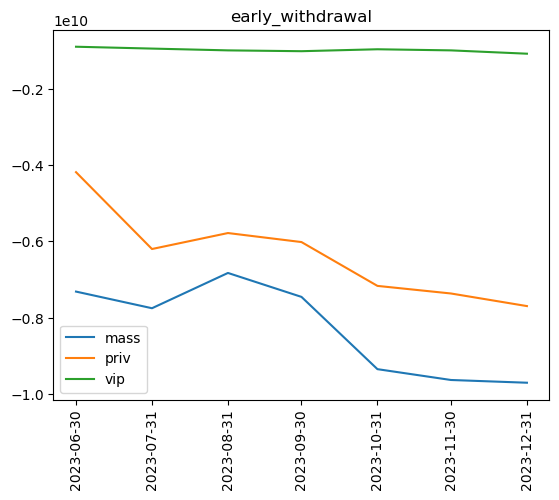

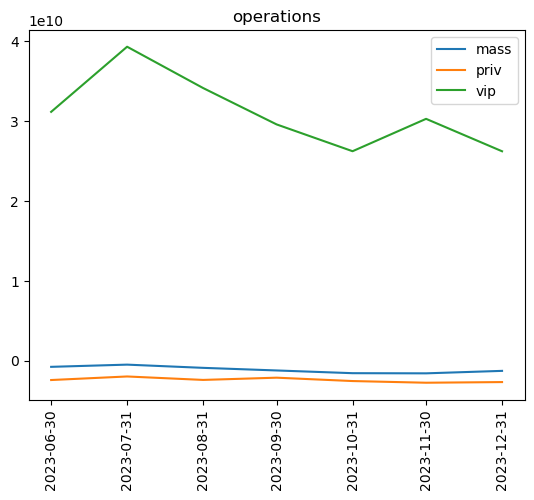

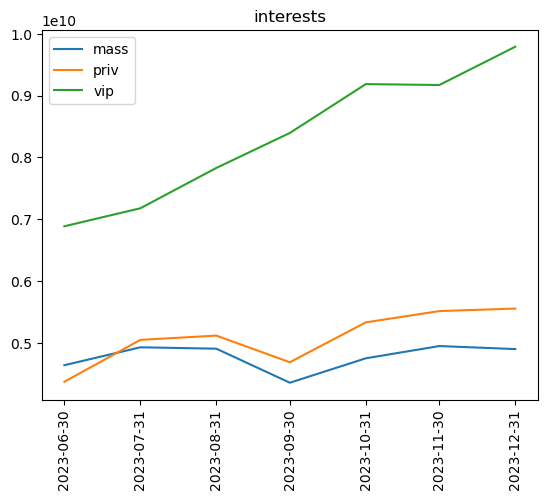

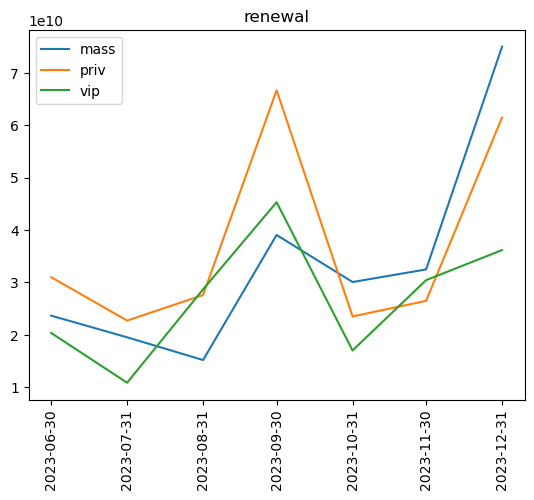

In [47]:
for col in mass.columns:
    plt.plot(mass.index, mass[col], label='mass')
    plt.plot(mass.index, priv[col], label='priv')
    plt.plot(mass.index, vip[col], label='vip')
    plt.xticks(mass.index, rotation=90)
    plt.legend()
    plt.title(col)
    plt.show()

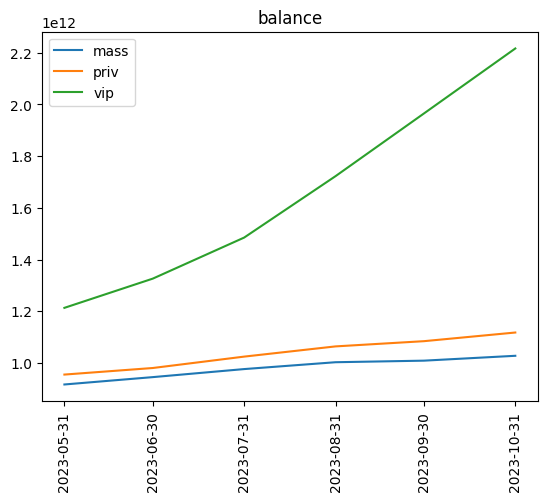

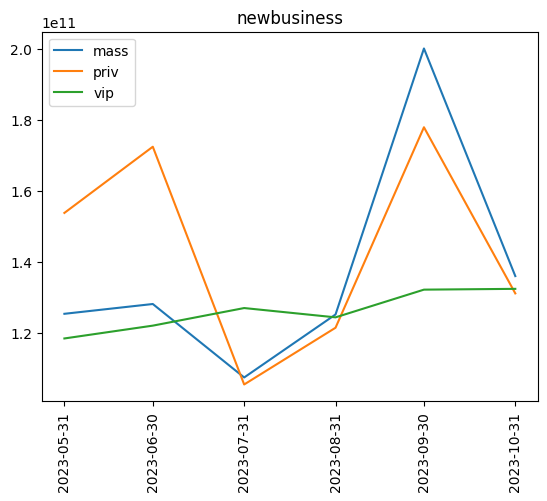

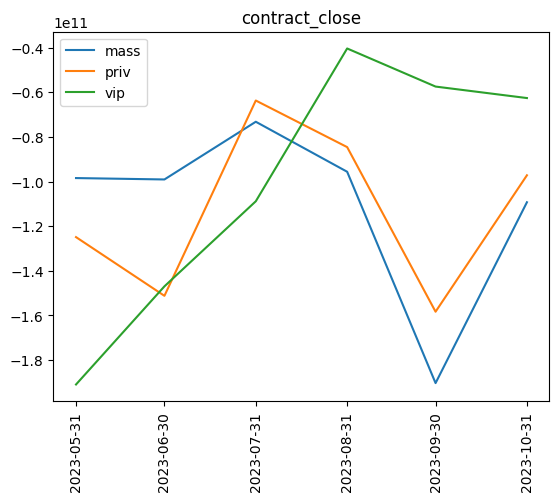

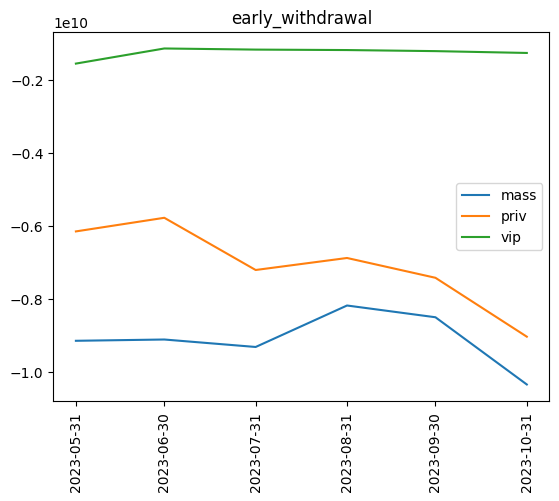

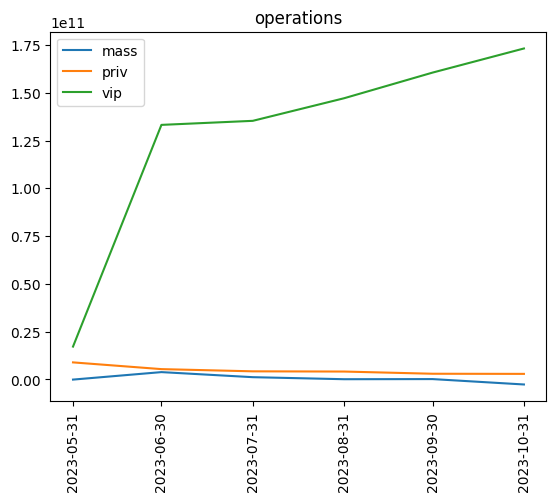

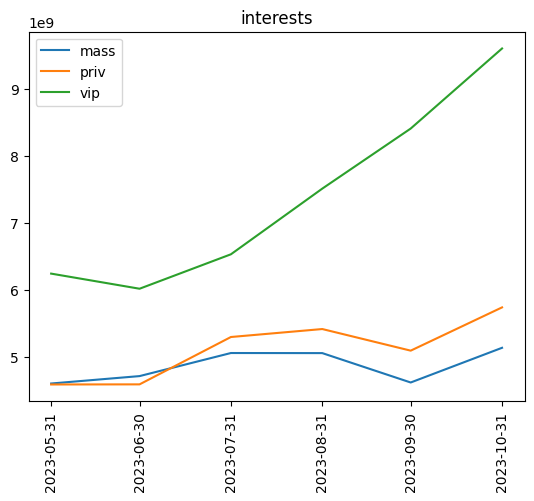

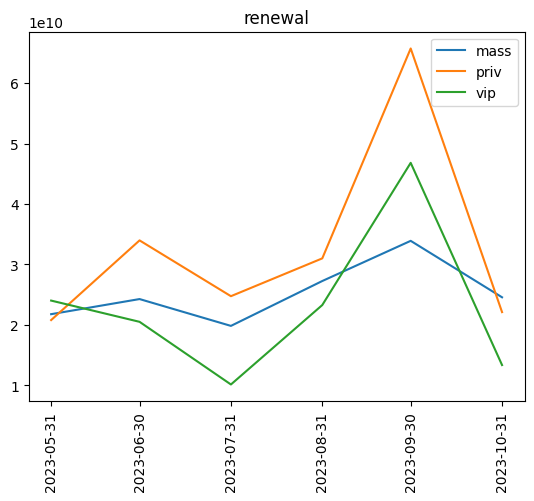

In [71]:
for col in mass.columns:
    plt.plot(mass.index, mass[col], label='mass')
    plt.plot(mass.index, priv[col], label='priv')
    plt.plot(mass.index, vip[col], label='vip')
    plt.xticks(mass.index, rotation=90)
    plt.legend()
    plt.title(col)
    plt.show()

In [86]:
portfolio[portfolio['is_vip_or_prv']==2]

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic
25,2023-04,5.0,2,NaN,3.0,7.0,2022-03,2023-09,7.0,2023-04-30,1.355295e+06,1.048467e+06,6.250000,6.909282e+07,6.909282e+07,2.0,1.0,2.000000,2022-03_2023-09_5.0_7.0_7.0_3_2_RUR,5.355263e+07,5.355263e+07,3.446073,3.446073,1.554019e+07,1.554019e+07,RUR,NaN,NaN,NaN,NaN,NaN,NaN,15540188.90,2,0.721311,6.909282e+07,3.446073
31,2023-04,4.0,2,1.0,3.0,7.0,2022-10,2023-09,7.0,2023-04-30,7.863115e+04,4.493208e+04,6.250000,2.224278e+06,2.224278e+06,1.0,1.0,30.000000,2022-10_2023-09_4.0_7.0_7.0_3_2_1.0_RUR,NaN,NaN,NaN,NaN,NaN,NaN,RUR,NaN,NaN,NaN,NaN,NaN,NaN,2224278.42,1,0.543284,2.224278e+06,NaN
35,2023-04,5.0,2,10.0,0.0,13.0,2022-11,2023-11,9.0,2023-04-30,1.200000e+05,1.600000e+05,8.000000,6.000000e+06,6.000000e+06,0.0,0.0,21.000000,2022-11_2023-11_5.0_13.0_9.0_0_2_10.0_RUR,0.000000e+00,0.000000e+00,0.000000,0.000000,6.000000e+06,6.000000e+06,RUR,NaN,NaN,NaN,NaN,NaN,NaN,6000000.00,3,0.413699,6.000000e+06,0.000000
37,2023-04,3.0,2,1.0,0.0,4.0,2022-12,2023-06,8.0,2023-04-30,7.294344e+05,5.835476e+05,6.977775,2.553591e+07,2.500918e+07,1.0,0.0,14.780012,2022-12_2023-06_3.0_4.0_8.0_0_2_1.0_RUR,1.341600e+05,0.000000e+00,0.005282,0.000000,2.540175e+07,2.500918e+07,RUR,NaN,NaN,NaN,NaN,NaN,NaN,25401749.63,2,0.664835,2.553591e+07,0.005282
39,2023-04,5.0,2,0.0,0.0,37.0,2023-01,2025-12,9.0,2023-04-30,1.510200e+05,1.510200e+05,8.390000,5.400000e+06,5.400000e+06,0.0,0.0,31.000000,2023-01_2025-12_5.0_37.0_9.0_0_2_0.0_RUR,0.000000e+00,0.000000e+00,0.000000,0.000000,5.400000e+06,5.400000e+06,RUR,NaN,6.989964,7.493570,7.633224,NaN,7.736187,5400000.00,4,0.084507,5.400000e+06,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9026,2023-04,2.0,2,0.0,0.0,19.0,2022-01,2023-07,8.0,2023-04-30,5.704000e+04,1.426000e+04,7.130000,6.555982e+05,6.000000e+05,0.0,0.0,20.000000,2022-01_2023-07_2.0_19.0_8.0_0_2_0.0_RUR,3.946180e+03,0.000000e+00,0.006056,0.000000,6.516520e+05,6.000000e+05,RUR,NaN,7.000000,7.404704,7.650000,NaN,7.437453,1460000.00,16,0.833333,6.555982e+05,0.006056
9029,2023-04,3.0,2,1.0,3.0,13.0,2022-04,2024-04,9.0,2023-04-30,3.033333e+05,3.733333e+04,6.000000,7.237727e+06,7.237727e+06,1.0,1.0,17.302229,2022-04_2024-04_3.0_13.0_9.0_3_2_1.0_RUR,NaN,NaN,NaN,NaN,NaN,NaN,RUR,NaN,NaN,NaN,NaN,NaN,NaN,7237726.86,1,0.499316,7.237727e+06,NaN
9035,2023-04,5.0,2,1.0,3.0,6.0,2022-09,2023-09,7.0,2023-04-30,3.503713e+06,1.751857e+06,6.250000,6.838475e+07,6.838475e+07,1.0,1.0,8.521490,2022-09_2023-09_5.0_6.0_7.0_3_2_1.0_RUR,1.702325e+07,1.702325e+07,0.331440,0.331440,5.136150e+07,5.136150e+07,RUR,NaN,NaN,NaN,NaN,NaN,NaN,51361498.80,2,0.580822,6.838475e+07,0.331440
9038,2023-04,3.0,2,0.0,3.0,7.0,2023-02,2023-07,7.0,2023-04-30,3.282732e+04,4.376976e+04,6.250000,2.167529e+06,2.167529e+06,0.0,1.0,31.000000,2023-02_2023-07_3.0_7.0_7.0_3_2_0.0_RUR,2.989840e+03,2.989840e+03,0.001381,0.001381,2.164539e+06,2.164539e+06,RUR,NaN,6.082648,6.215359,6.000000,NaN,6.091178,2100948.57,3,0.393333,2.167529e+06,0.001381


23/06/07 04:26:10 ERROR cluster.YarnClientSchedulerBackend: YARN application has exited unexpectedly with state SUCCEEDED! Check the YARN application logs for more details.
23/06/07 04:28:10 ERROR util.Utils: Uncaught exception in thread YARN application state monitor
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [120 seconds]. This timeout is controlled by spark.rpc.askTimeout
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:36)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.scheduler.cluster.CoarseGrainedSchedulerBackend.requestTotalExecutors(CoarseGrainedSchedulerBackend.scala:594)
